In [1]:
import spacy
import pandas as pd
import string
from tqdm import tqdm
import ast
import re
import emoji
import numpy as np


In [2]:
data=pd.read_csv(r"/Users/abhijeetburagohain/Downloads/laptops_dataset_final_600.csv")

In [2]:
## Loading the spacy 
nlp = spacy.load("en_core_web_sm")

In [4]:
## Appling tokenization to the 'review' column
data['tokens'] = data['review'].apply(lambda x: [token.text for token in nlp(x)] if pd.notnull(x) else [])

## Appling tokenization to the 'title' column
data['tokens_title'] = data['title'].apply(lambda x: [token.text for token in nlp(x)] if pd.notnull(x) else [])

In [3]:
def safe_lower(tokens):
    if isinstance(tokens, list):
        return [str(token).lower().strip() for token in tokens]
    return tokens

data['tokens'] = data['tokens'].apply(safe_lower)
data['tokens_title'] = data['tokens_title'].apply(safe_lower)

In [4]:
## Removing the stop words
stopwords = nlp.Defaults.stop_words
punctuations = string.punctuation

def clean_tokens(token_list):
    return [
        token for token in token_list
        if token.lower() not in stopwords and token not in punctuations
    ]

data['clean_tokens'] = data['tokens'].apply(clean_tokens)
data['tokens_title'] = data['tokens_title'].apply(clean_tokens)

In [5]:
### FUNCTIONS FOR CLEANING THE UNWANTED SYMBOLS
def remove_prefix_noise(token):
    # Remove patterns like '1)', '2)', etc.
    token = re.sub(r'^\d+\)', '', token)

    # Remove patterns like '1.', '2.', etc. ONLY if not followed by a digit (e.g. 1.design, not 1.5)
    token = re.sub(r'^\d+\.(?=[a-zA-Z])', '', token)

    # Remove patterns like '3-', '4-', etc. at the start
    token = re.sub(r'^\d+-:-;-', '', token)

    return token


def remove_unwanted_symbols(token_list):
    bad_tokens = {"", "\n", "\\n", "..", "...", ".", "️", '....','\n\n','\n\n\n','.......','......',
                    '):','-)',"--------","----","---","--","-",'.....', '........', '.........', '..........', '............', '.............', '..............', '................',
                    '/-','-','-)',',',"#","&"}  # include the invisible '️'
    cleaned = [token.strip() for token in token_list if token.strip() not in bad_tokens]
    cleaned = [
        "" if token.lstrip("-/\\.#&") in bad_tokens else remove_prefix_noise(token.lstrip("-/\\.#&"))
        for token in cleaned
        ]
    return cleaned


data['clean_tokens'] = data['clean_tokens'].apply(remove_unwanted_symbols)
data['tokens_title'] = data['tokens_title'].apply(remove_unwanted_symbols)

In [6]:
# Normalize number strings inside individual tokens
def normalize_token(token):
    if isinstance(token, str):
        # Convert "23,000" → "23000"
        token = re.sub(r'(\d{1,3}(?:,\d{3})+)', lambda m: m.group(1).replace(',', ''), token)
        # Convert "23k"/"23K" → "23000"
        token = re.sub(r'^(\d+)[kKk.]$', lambda m: str(int(m.group(1)) * 1000), token)
        token = re.sub(r'^(\d+)(lakh|lakhs)$', lambda m: str(int(m.group(1)) * 100000), token, flags=re.IGNORECASE)
    return token

# Apply it to each token in the list
def normalize_token_list(token_list):
    return [normalize_token(token) for token in token_list]

# Apply to your DataFrame column
data['clean_tokens'] = data['clean_tokens'].apply(normalize_token_list)
data['tokens_title'] = data['tokens_title'].apply(normalize_token_list)


In [9]:
## CORRECTING SPELLINGS CAN ALSO INTRODUCE NEW SPELLING ERRORS INTO THE CORPUS, WHICH CAN DE-ENHANCE THE MODEL
## PERFORMANCE, AND ALSO SPELLING CORRECTTING IS COMPUTATIONALLY CUMBERSOME. SO WE WILL ONLY GET A
##  FEATURE (SPELLING ERROR), TO GET THE IDEA OF THE QUALITY OF THE REVIEW , IT WILL BE IN THE FEATURE ENGINEERING 
##  PART

In [10]:
### Extracting Hindi words from the corpus

In [7]:
hindi_to_eng = {
    "bakwas": "nonsense",
    "zabardast": "awesome",
    "achha": "good",
    "ghatiya": "bad",
    "mast": "great"
}

def translate_hindi_words(tokens):
    return [hindi_to_eng.get(word.lower(), word) for word in tokens]

data['clean_tokens'] = data['clean_tokens'].apply(translate_hindi_words)
data['tokens_title'] = data['tokens_title'].apply(translate_hindi_words)

In [12]:
## Checking for empty clean tokens list and replacing it with the tokens from the title tokens column
data["clean_tokens_length"]=data['clean_tokens'].apply(lambda x: len(x))
data.loc[data["clean_tokens_length"] == 0, "clean_tokens"] = data["tokens_title"]

In [13]:
## Creating lemmas for the review column

tqdm.pandas()  # Optional: adds a nice progress bar

valid_rows = data['clean_tokens'].apply(lambda x: isinstance(x, list))               # Step 1: Filter rows with valid lists of tokens
texts = data.loc[valid_rows, 'clean_tokens'].apply(lambda tokens: " ".join(tokens))  # Step 2: Join tokens into text for spaCy processing
docs = list(nlp.pipe(texts, batch_size=50))                                          # Step 3: Process in batch with nlp.pipe
lemmatized = [[token.lemma_ for token in doc] for doc in docs]                       # Step 4: Extract lemmas from each Doc

# Create the column first as object type to handle sequences
data['lemmatized_tokens'] = None
data.loc[valid_rows, 'lemmatized_tokens'] = pd.Series(lemmatized, index=data.loc[valid_rows].index)


In [14]:
data.to_csv("cleaned_data.csv")

In [3]:
## Reading the dataset [preprossed]
data=pd.read_csv("cleaned_data.csv")

Will read the feature engineered file, and run the models agian incorparating the features and compare the model performance and choose the best model for our project

In [3]:
## Reading the feature engineered file
data=pd.read_csv(r"data_feature_engineered.csv",low_memory=False)

In [4]:
## Selecting the featurs that are needed to incorpoarte into the models

features=['sentiment_polarity', 'sentiment_subjectivity','sentiment_polarity_2', 'sentiment_subjectivity_2', 
            'vader_title','vader_review','vader_weighted_avg', 'flesch_reading_ease',
            'flesch_kincaid_grade','noun_count', 'verb_count', 'adj_count', 'person_count', 'org_count',
            'gpe_count','topic_0', 'topic_1','count_of_spelling_errors']

In [5]:
## Scaling the feautures 
from sklearn.preprocessing import StandardScaler

manual_features = data[features]
scaler = StandardScaler()
scaled_manual = scaler.fit_transform(manual_features)

In [7]:
data['lemmatized_tokens'] = data['lemmatized_tokens'].apply(ast.literal_eval)

### EMOJIS CLEANING [CONVERTING THEM TO TEXTS]
def demojize_tokens(tokens):
    return [emoji.demojize(token, language='en') for token in tokens]

data['clean_tokens_demojize'] = data['lemmatized_tokens'].apply(demojize_tokens)

# Join tokens back to text format
data['clean_text'] = data['clean_tokens_demojize'].apply(lambda x: ' '.join(x))

In [8]:
###  Making a sentiment column
## the sentiment is changed to 2 , because getting less accuracy in neutral, because of less samples and underfitting
def get_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

data['sentiment'] = data['rating'].apply(get_sentiment)

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(data['sentiment'])  # 0 = negative, 1 = neutral, 2 = positive

In [18]:
### WILL LATER TRY ON WORD2VEC

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back to text format
# data['clean_text'] = data['lemmatized_tokens'].apply(lambda x: ' '.join(x))

tfidf = TfidfVectorizer(max_features=5000)  # You can adjust max_features
X = tfidf.fit_transform(data['clean_text'])

print(X.shape)  # (rows, features)


In [11]:
## Adding the features to the tf-idf matrix

from scipy.sparse import hstack

X = hstack([X, scaled_manual])  # Final feature matrix

In [12]:
X.shape

(24113, 5018)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


MODELLING

In [28]:
### RANDOM FORREST CLASSIFIER

In [ ]:
### DOING A RANDOMSEARCHcv TO GET THE BEST PARAMS [appling smote and standard cv]

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import randint
import numpy as np

# Define the pipeline with SMOTE and RandomForestClassifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'rf__n_estimators': randint(100, 301),  # Randomly select n_estimators between 100 and 300
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=5,  # Number of parameter settings sampled
    scoring='f1_macro',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


In [48]:
## applying SMOTE and Stratified K fold

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from scipy.stats import randint
import numpy as np

# Use SMOTEN instead of SMOTE
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'rf__n_estimators': randint(100, 301),
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__criterion': ['gini', 'entropy']  # Fixed parameter name prefix
}

# Use StratifiedKFold to maintain class distribution in each fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=7,
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END rf__criterion=gini, rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=171; total time=  15.5s
[CV] END rf__criterion=gini, rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=171; total time=  15.8s
[CV] END rf__criterion=gini, rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=171; total time=  15.9s
[CV] END rf__criterion=gini, rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=171; total time=  16.0s
[CV] END rf__criterion=gini, rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=2, rf__n_estimators=171; total time=  15.8s
[CV] END rf__criterion=gini, rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=5, rf__n_estimators=174; total time=  16.1s
[CV] END rf__criterion=gini, rf__max_depth=10, rf__max_features=sqrt, rf__min_samples_split=5, rf__n_estimators=174; total t

In [49]:
from sklearn.metrics import classification_report
# Predict on the test set
y_pred = random_search.best_estimator_.predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       507
           1       0.64      0.74      0.69       376
           2       0.98      0.96      0.97      3940

    accuracy                           0.94      4823
   macro avg       0.84      0.88      0.86      4823
weighted avg       0.94      0.94      0.94      4823



In [107]:
X_test.shape

(4823, 5018)

In [50]:
from sklearn.metrics import classification_report, accuracy_score

# On training set
y_train_pred = random_search.best_estimator_.predict(X_train)
print("Training Report:")
print(classification_report(y_train, y_train_pred))
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

# On test set
y_test_pred = random_search.best_estimator_.predict(X_test)
print("Test Report:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


Training Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1970
           1       0.74      0.84      0.79      1659
           2       0.98      0.96      0.97     15661

    accuracy                           0.95     19290
   macro avg       0.88      0.92      0.90     19290
weighted avg       0.95      0.95      0.95     19290

Training Accuracy: 0.9515292897874547
Test Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       507
           1       0.64      0.74      0.69       376
           2       0.98      0.96      0.97      3940

    accuracy                           0.94      4823
   macro avg       0.84      0.88      0.86      4823
weighted avg       0.94      0.94      0.94      4823

Test Accuracy: 0.9396641094754302


In [ ]:
## SVM [Support Vector Machines] [Excluding the SVM, because : 1--> high dimensional data,
## 2--> time taking,3-->High parameter tuning complexity]

In [ ]:
# from sklearn.svm import SVC
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from scipy.stats import uniform

# # Define pipeline
# pipeline_svm = Pipeline([
#     ('smote', SMOTE(random_state=42)),
#     ('svm', SVC(probability=True))
# ])

# # Hyperparameter distributions
# param_distributions_svm = {
#     'svm__C': uniform(0.1, 10),           # Regularization parameter
#     'svm__kernel': ['linear', 'rbf'],     # Linear or RBF kernel
#     'svm__gamma': ['scale', 'auto']       # Kernel coefficient
# }

# # Stratified K-Fold CV
# cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # RandomizedSearchCV for SVM
# random_search_svm = RandomizedSearchCV(
#     estimator=pipeline_svm,
#     param_distributions=param_distributions_svm,
#     n_iter=10,
#     scoring='f1_macro',
#     cv=cv_strategy,
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )

# # Fit model
# random_search_svm.fit(X_train, y_train)

# print("SVM Best Parameters:", random_search_svm.best_params_)
# print("SVM Best Score:", random_search_svm.best_score_)


In [ ]:
# from sklearn.svm import SVC

# # Initialize the SVM model with class weight balanced
# svm_model = SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42)

# # Train the model
# svm_model.fit(X_train, y_train)

# # Predict on the test set
# y_pred = svm_model.predict(X_test)

# # Print the classification report
# print(classification_report(y_test, y_pred))


In [ ]:
### XGBOOST 

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform

# Define pipeline
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

# Hyperparameter distributions
param_distributions_xgb = {
    'xgb__n_estimators': randint(100, 300),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__reg_alpha': uniform(0, 1),
    'xgb__reg_lambda': uniform(0, 1),
    'xgb__min_child_weight': randint(1, 10),
    'xgb__gamma': uniform(0, 1)
}

# Stratified K-Fold CV
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_distributions_xgb,
    n_iter=10,
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit model
random_search_xgb.fit(X_train, y_train)

print("XGBoost Best Parameters:", random_search_xgb.best_params_)
print("XGBoost Best Score:", random_search_xgb.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:39:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:39:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:39:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:39:07] WARNING: /Users/runner/work/xgboost/xgboost/

[CV] END xgb__colsample_bytree=0.749816047538945, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.15639878836228102, xgb__max_depth=7, xgb__min_child_weight=5, xgb__n_estimators=202, xgb__reg_alpha=0.44583275285359114, xgb__reg_lambda=0.09997491581800289, xgb__subsample=0.7836995567863468; total time= 1.3min
[CV] END xgb__colsample_bytree=0.749816047538945, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.15639878836228102, xgb__max_depth=7, xgb__min_child_weight=5, xgb__n_estimators=202, xgb__reg_alpha=0.44583275285359114, xgb__reg_lambda=0.09997491581800289, xgb__subsample=0.7836995567863468; total time= 1.3min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:40:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.749816047538945, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.15639878836228102, xgb__max_depth=7, xgb__min_child_weight=5, xgb__n_estimators=202, xgb__reg_alpha=0.44583275285359114, xgb__reg_lambda=0.09997491581800289, xgb__subsample=0.7836995567863468; total time= 1.3min
[CV] END xgb__colsample_bytree=0.749816047538945, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.15639878836228102, xgb__max_depth=7, xgb__min_child_weight=5, xgb__n_estimators=202, xgb__reg_alpha=0.44583275285359114, xgb__reg_lambda=0.09997491581800289, xgb__subsample=0.7836995567863468; total time= 1.3min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:40:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:40:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:40:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.749816047538945, xgb__gamma=0.9507143064099162, xgb__learning_rate=0.15639878836228102, xgb__max_depth=7, xgb__min_child_weight=5, xgb__n_estimators=202, xgb__reg_alpha=0.44583275285359114, xgb__reg_lambda=0.09997491581800289, xgb__subsample=0.7836995567863468; total time= 1.2min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:41:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7334834444556088, xgb__gamma=0.14286681792194078, xgb__learning_rate=0.14017769458977059, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=187, xgb__reg_alpha=0.8324426408004217, xgb__reg_lambda=0.21233911067827616, xgb__subsample=0.6727299868828402; total time= 1.9min
[CV] END xgb__colsample_bytree=0.7334834444556088, xgb__gamma=0.14286681792194078, xgb__learning_rate=0.14017769458977059, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=187, xgb__reg_alpha=0.8324426408004217, xgb__reg_lambda=0.21233911067827616, xgb__subsample=0.6727299868828402; total time= 1.9min
[CV] END xgb__colsample_bytree=0.7334834444556088, xgb__gamma=0.14286681792194078, xgb__learning_rate=0.14017769458977059, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=187, xgb__reg_alpha=0.8324426408004217, xgb__reg_lambda=0.21233911067827616, xgb__subsample=0.6727299868828402; total time= 1.9min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:42:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.6733618039413735, xgb__gamma=0.3042422429595377, xgb__learning_rate=0.11495128632644756, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=148, xgb__reg_alpha=0.5247746602583891, xgb__reg_lambda=0.3998609717152555, xgb__subsample=0.6186662652854461; total time=  53.3s


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:43:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.6733618039413735, xgb__gamma=0.3042422429595377, xgb__learning_rate=0.11495128632644756, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=148, xgb__reg_alpha=0.5247746602583891, xgb__reg_lambda=0.3998609717152555, xgb__subsample=0.6186662652854461; total time=  54.8s


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:43:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7334834444556088, xgb__gamma=0.14286681792194078, xgb__learning_rate=0.14017769458977059, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=187, xgb__reg_alpha=0.8324426408004217, xgb__reg_lambda=0.21233911067827616, xgb__subsample=0.6727299868828402; total time= 1.9min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:43:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.6733618039413735, xgb__gamma=0.3042422429595377, xgb__learning_rate=0.11495128632644756, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=148, xgb__reg_alpha=0.5247746602583891, xgb__reg_lambda=0.3998609717152555, xgb__subsample=0.6186662652854461; total time=  54.1s


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:44:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.6733618039413735, xgb__gamma=0.3042422429595377, xgb__learning_rate=0.11495128632644756, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=148, xgb__reg_alpha=0.5247746602583891, xgb__reg_lambda=0.3998609717152555, xgb__subsample=0.6186662652854461; total time=  54.5s


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:44:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.7334834444556088, xgb__gamma=0.14286681792194078, xgb__learning_rate=0.14017769458977059, xgb__max_depth=7, xgb__min_child_weight=2, xgb__n_estimators=187, xgb__reg_alpha=0.8324426408004217, xgb__reg_lambda=0.21233911067827616, xgb__subsample=0.6727299868828402; total time= 2.0min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:44:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.6733618039413735, xgb__gamma=0.3042422429595377, xgb__learning_rate=0.11495128632644756, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=148, xgb__reg_alpha=0.5247746602583891, xgb__reg_lambda=0.3998609717152555, xgb__subsample=0.6186662652854461; total time=  54.7s


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:44:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9895022075365837, xgb__gamma=0.23277134043030423, xgb__learning_rate=0.02812128690656416, xgb__max_depth=8, xgb__min_child_weight=3, xgb__n_estimators=207, xgb__reg_alpha=0.5142344384136116, xgb__reg_lambda=0.5924145688620425, xgb__subsample=0.6185801650879991; total time= 4.4min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9895022075365837, xgb__gamma=0.23277134043030423, xgb__learning_rate=0.02812128690656416, xgb__max_depth=8, xgb__min_child_weight=3, xgb__n_estimators=207, xgb__reg_alpha=0.5142344384136116, xgb__reg_lambda=0.5924145688620425, xgb__subsample=0.6185801650879991; total time= 4.4min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9895022075365837, xgb__gamma=0.23277134043030423, xgb__learning_rate=0.02812128690656416, xgb__max_depth=8, xgb__min_child_weight=3, xgb__n_estimators=207, xgb__reg_alpha=0.5142344384136116, xgb__reg_lambda=0.5924145688620425, xgb__subsample=0.6185801650879991; total time= 4.6min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9895022075365837, xgb__gamma=0.23277134043030423, xgb__learning_rate=0.02812128690656416, xgb__max_depth=8, xgb__min_child_weight=3, xgb__n_estimators=207, xgb__reg_alpha=0.5142344384136116, xgb__reg_lambda=0.5924145688620425, xgb__subsample=0.6185801650879991; total time= 4.4min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8430179407605753, xgb__gamma=0.17052412368729153, xgb__learning_rate=0.023010318597055907, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=159, xgb__reg_alpha=0.5632882178455393, xgb__reg_lambda=0.3854165025399161, xgb__subsample=0.6063865008880857; total time= 1.7min
[CV] END xgb__colsample_bytree=0.8430179407605753, xgb__gamma=0.17052412368729153, xgb__learning_rate=0.023010318597055907, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=159, xgb__reg_alpha=0.5632882178455393, xgb__reg_lambda=0.3854165025399161, xgb__subsample=0.6063865008880857; total time= 1.7min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:50:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:50:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8430179407605753, xgb__gamma=0.17052412368729153, xgb__learning_rate=0.023010318597055907, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=159, xgb__reg_alpha=0.5632882178455393, xgb__reg_lambda=0.3854165025399161, xgb__subsample=0.6063865008880857; total time= 1.7min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:50:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.6923575302488596, xgb__gamma=0.24102546602601171, xgb__learning_rate=0.14665270376509165, xgb__max_depth=6, xgb__min_child_weight=8, xgb__n_estimators=274, xgb__reg_alpha=0.17336465350777208, xgb__reg_lambda=0.3910606075732408, xgb__subsample=0.672894435115225; total time= 1.3min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:51:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8430179407605753, xgb__gamma=0.17052412368729153, xgb__learning_rate=0.023010318597055907, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=159, xgb__reg_alpha=0.5632882178455393, xgb__reg_lambda=0.3854165025399161, xgb__subsample=0.6063865008880857; total time= 1.5min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:51:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.8430179407605753, xgb__gamma=0.17052412368729153, xgb__learning_rate=0.023010318597055907, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=159, xgb__reg_alpha=0.5632882178455393, xgb__reg_lambda=0.3854165025399161, xgb__subsample=0.6063865008880857; total time= 1.6min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:52:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.6923575302488596, xgb__gamma=0.24102546602601171, xgb__learning_rate=0.14665270376509165, xgb__max_depth=6, xgb__min_child_weight=8, xgb__n_estimators=274, xgb__reg_alpha=0.17336465350777208, xgb__reg_lambda=0.3910606075732408, xgb__subsample=0.672894435115225; total time= 1.2min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:52:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9895022075365837, xgb__gamma=0.23277134043030423, xgb__learning_rate=0.02812128690656416, xgb__max_depth=8, xgb__min_child_weight=3, xgb__n_estimators=207, xgb__reg_alpha=0.5142344384136116, xgb__reg_lambda=0.5924145688620425, xgb__subsample=0.6185801650879991; total time= 4.5min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:53:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.6923575302488596, xgb__gamma=0.24102546602601171, xgb__learning_rate=0.14665270376509165, xgb__max_depth=6, xgb__min_child_weight=8, xgb__n_estimators=274, xgb__reg_alpha=0.17336465350777208, xgb__reg_lambda=0.3910606075732408, xgb__subsample=0.672894435115225; total time= 1.2min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:53:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.6923575302488596, xgb__gamma=0.24102546602601171, xgb__learning_rate=0.14665270376509165, xgb__max_depth=6, xgb__min_child_weight=8, xgb__n_estimators=274, xgb__reg_alpha=0.17336465350777208, xgb__reg_lambda=0.3910606075732408, xgb__subsample=0.672894435115225; total time= 1.2min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:53:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.6923575302488596, xgb__gamma=0.24102546602601171, xgb__learning_rate=0.14665270376509165, xgb__max_depth=6, xgb__min_child_weight=8, xgb__n_estimators=274, xgb__reg_alpha=0.17336465350777208, xgb__reg_lambda=0.3910606075732408, xgb__subsample=0.672894435115225; total time= 1.2min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:54:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.902144564127061, xgb__gamma=0.4251558744912447, xgb__learning_rate=0.05158833257363777, xgb__max_depth=6, xgb__min_child_weight=6, xgb__n_estimators=290, xgb__reg_alpha=0.8422847745949985, xgb__reg_lambda=0.44975413336976566, xgb__subsample=0.7580600944007257; total time= 2.0min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:55:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.902144564127061, xgb__gamma=0.4251558744912447, xgb__learning_rate=0.05158833257363777, xgb__max_depth=6, xgb__min_child_weight=6, xgb__n_estimators=290, xgb__reg_alpha=0.8422847745949985, xgb__reg_lambda=0.44975413336976566, xgb__subsample=0.7580600944007257; total time= 2.0min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:55:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.902144564127061, xgb__gamma=0.4251558744912447, xgb__learning_rate=0.05158833257363777, xgb__max_depth=6, xgb__min_child_weight=6, xgb__n_estimators=290, xgb__reg_alpha=0.8422847745949985, xgb__reg_lambda=0.44975413336976566, xgb__subsample=0.7580600944007257; total time= 2.0min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:55:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.902144564127061, xgb__gamma=0.4251558744912447, xgb__learning_rate=0.05158833257363777, xgb__max_depth=6, xgb__min_child_weight=6, xgb__n_estimators=290, xgb__reg_alpha=0.8422847745949985, xgb__reg_lambda=0.44975413336976566, xgb__subsample=0.7580600944007257; total time= 2.0min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:56:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.902144564127061, xgb__gamma=0.4251558744912447, xgb__learning_rate=0.05158833257363777, xgb__max_depth=6, xgb__min_child_weight=6, xgb__n_estimators=290, xgb__reg_alpha=0.8422847745949985, xgb__reg_lambda=0.44975413336976566, xgb__subsample=0.7580600944007257; total time= 2.0min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:57:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9706635463175177, xgb__gamma=0.7272719958564209, xgb__learning_rate=0.07530815376116708, xgb__max_depth=8, xgb__min_child_weight=7, xgb__n_estimators=289, xgb__reg_alpha=0.32533033076326434, xgb__reg_lambda=0.388677289689482, xgb__subsample=0.7085396127095583; total time= 2.3min
[CV] END xgb__colsample_bytree=0.9706635463175177, xgb__gamma=0.7272719958564209, xgb__learning_rate=0.07530815376116708, xgb__max_depth=8, xgb__min_child_weight=7, xgb__n_estimators=289, xgb__reg_alpha=0.32533033076326434, xgb__reg_lambda=0.388677289689482, xgb__subsample=0.7085396127095583; total time= 2.3min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:57:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:57:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9706635463175177, xgb__gamma=0.7272719958564209, xgb__learning_rate=0.07530815376116708, xgb__max_depth=8, xgb__min_child_weight=7, xgb__n_estimators=289, xgb__reg_alpha=0.32533033076326434, xgb__reg_lambda=0.388677289689482, xgb__subsample=0.7085396127095583; total time= 2.2min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:58:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9314950036607718, xgb__gamma=0.3567533266935893, xgb__learning_rate=0.06618690193747616, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=256, xgb__reg_alpha=0.8021969807540397, xgb__reg_lambda=0.07455064367977082, xgb__subsample=0.9947547746402069; total time= 1.6min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9706635463175177, xgb__gamma=0.7272719958564209, xgb__learning_rate=0.07530815376116708, xgb__max_depth=8, xgb__min_child_weight=7, xgb__n_estimators=289, xgb__reg_alpha=0.32533033076326434, xgb__reg_lambda=0.388677289689482, xgb__subsample=0.7085396127095583; total time= 2.3min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9706635463175177, xgb__gamma=0.7272719958564209, xgb__learning_rate=0.07530815376116708, xgb__max_depth=8, xgb__min_child_weight=7, xgb__n_estimators=289, xgb__reg_alpha=0.32533033076326434, xgb__reg_lambda=0.388677289689482, xgb__subsample=0.7085396127095583; total time= 2.3min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9314950036607718, xgb__gamma=0.3567533266935893, xgb__learning_rate=0.06618690193747616, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=256, xgb__reg_alpha=0.8021969807540397, xgb__reg_lambda=0.07455064367977082, xgb__subsample=0.9947547746402069; total time= 1.6min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9314950036607718, xgb__gamma=0.3567533266935893, xgb__learning_rate=0.06618690193747616, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=256, xgb__reg_alpha=0.8021969807540397, xgb__reg_lambda=0.07455064367977082, xgb__subsample=0.9947547746402069; total time= 1.6min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:00:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9314950036607718, xgb__gamma=0.3567533266935893, xgb__learning_rate=0.06618690193747616, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=256, xgb__reg_alpha=0.8021969807540397, xgb__reg_lambda=0.07455064367977082, xgb__subsample=0.9947547746402069; total time= 1.5min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:00:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.9314950036607718, xgb__gamma=0.3567533266935893, xgb__learning_rate=0.06618690193747616, xgb__max_depth=6, xgb__min_child_weight=9, xgb__n_estimators=256, xgb__reg_alpha=0.8021969807540397, xgb__reg_lambda=0.07455064367977082, xgb__subsample=0.9947547746402069; total time= 1.6min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:01:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.908897907718663, xgb__gamma=0.1987156815341724, xgb__learning_rate=0.01110442342472048, xgb__max_depth=5, xgb__min_child_weight=3, xgb__n_estimators=180, xgb__reg_alpha=0.71134195274865, xgb__reg_lambda=0.7901755405312056, xgb__subsample=0.8423839899124046; total time= 1.9min


/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:01:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END xgb__colsample_bytree=0.908897907718663, xgb__gamma=0.1987156815341724, xgb__learning_rate=0.01110442342472048, xgb__max_depth=5, xgb__min_child_weight=3, xgb__n_estimators=180, xgb__reg_alpha=0.71134195274865, xgb__reg_lambda=0.7901755405312056, xgb__subsample=0.8423839899124046; total time= 1.8min
[CV] END xgb__colsample_bytree=0.908897907718663, xgb__gamma=0.1987156815341724, xgb__learning_rate=0.01110442342472048, xgb__max_depth=5, xgb__min_child_weight=3, xgb__n_estimators=180, xgb__reg_alpha=0.71134195274865, xgb__reg_lambda=0.7901755405312056, xgb__subsample=0.8423839899124046; total time= 1.8min
[CV] END xgb__colsample_bytree=0.908897907718663, xgb__gamma=0.1987156815341724, xgb__learning_rate=0.01110442342472048, xgb__max_depth=5, xgb__min_child_weight=3, xgb__n_estimators=180, xgb__reg_alpha=0.71134195274865, xgb__reg_lambda=0.7901755405312056, xgb__subsample=0.8423839899124046; total time= 1.6min
[CV] END xgb__colsample_bytree=0.908897907718663, xgb__gamma=0.1987156

/Users/abhijeetburagohain/spacy_env/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:03:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best Parameters: {'xgb__colsample_bytree': 0.7334834444556088, 'xgb__gamma': 0.14286681792194078, 'xgb__learning_rate': 0.14017769458977059, 'xgb__max_depth': 7, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 187, 'xgb__reg_alpha': 0.8324426408004217, 'xgb__reg_lambda': 0.21233911067827616, 'xgb__subsample': 0.6727299868828402}
XGBoost Best Score: 0.9290013496637688


In [85]:
## Getting the feature importance of best model "XGBoost"

                   feature  importance
5004           vader_title    0.032612
5006    vader_weighted_avg    0.020619
2900               monotor    0.014383
1816              external    0.013653
3700           replacement    0.012851
1285                  cons    0.011656
5002  sentiment_polarity_2    0.011529
3715                resive    0.010331
1451            decription    0.009510
4399                  thay    0.009026


/var/folders/fm/6g7pnjfx1fg8q710r999g5v40000gn/T/ipykernel_26122/3672367168.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature', palette='coolwarm')


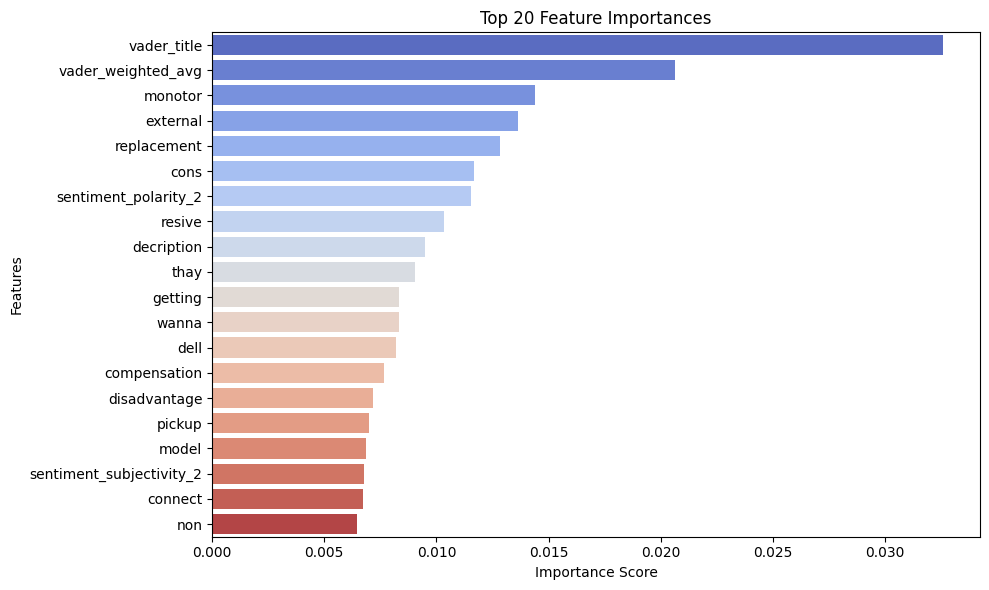

In [17]:
# Get the best trained model from the search
best_model = random_search_xgb.best_estimator_

# Now access the underlying classifier (if it's a pipeline)
# Assuming you used a pipeline, extract the classifier
xgb_clf = best_model.named_steps['xgb']  # Replace 'xgb' with the correct step name

# Get feature importances
importances = xgb_clf.feature_importances_

# Feature Names
tfidf_feature_names = tfidf.get_feature_names_out()
manual_feature_names = manual_features.columns  # replace with actual DataFrame if needed

all_feature_names = np.concatenate([tfidf_feature_names, manual_feature_names])

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Print top features
print(feat_imp_df.head(10))

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(20), x='importance', y='feature', palette='coolwarm')
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import classification_report
# Predict on the test set
y_pred = random_search_xgb.best_estimator_.predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       507
           1       0.79      0.87      0.83       376
           2       0.99      0.98      0.98      3940

    accuracy                           0.97      4823
   macro avg       0.92      0.94      0.93      4823
weighted avg       0.97      0.97      0.97      4823



In [19]:
from sklearn.metrics import classification_report, accuracy_score

# On training set
y_train_pred = random_search_xgb.best_estimator_.predict(X_train)
print("Training Report:")
print(classification_report(y_train, y_train_pred))
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

# On test set
y_test_pred = random_search_xgb.best_estimator_.predict(X_test)
print("Test Report:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Training Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1970
           1       0.93      0.95      0.94      1659
           2       0.99      0.99      0.99     15661

    accuracy                           0.99     19290
   macro avg       0.97      0.98      0.97     19290
weighted avg       0.99      0.99      0.99     19290

Training Accuracy: 0.9875583203732504
Test Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       507
           1       0.79      0.87      0.83       376
           2       0.99      0.98      0.98      3940

    accuracy                           0.97      4823
   macro avg       0.92      0.94      0.93      4823
weighted avg       0.97      0.97      0.97      4823

Test Accuracy: 0.9693137051627617


In [22]:
## KNN

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint

# Define pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

# Parameter grid
param_dist = {
    'knn__n_neighbors': randint(3, 21),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]  # 1: Manhattan, 2: Euclidean
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
random_search_knn = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=7,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit
random_search_knn.fit(X_train, y_train)

# Results
print("Best Parameters:", random_search_knn.best_params_)
print("Best Score:", random_search_knn.best_score_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time= 1.4min
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time= 1.4min
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time= 1.4min
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time= 1.4min
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time=  23.0s
[CV] END knn__n_neighbors=17, knn__p=1, knn__weights=distance; total time=  35.8s
[CV] END knn__n_neighbors=17, knn__p=1, knn__weights=distance; total time=  35.8s
[CV] END knn__n_neighbors=17, knn__p=1, knn__weights=distance; total time=  36.3s
[CV] END knn__n_neighbors=17, knn__p=1, knn__weights=distance; total time=  45.5s
[CV] END .knn__n_neighbors=9, knn__p=2, knn__weights=uniform; total time=  39.9s
[CV] END knn__n_neighbors=17, knn__p=1, knn__weights=distance; total time=  41.0s
[CV] END .knn__n_neighbors=9, knn__p=2, knn_

In [57]:
from sklearn.metrics import classification_report
# Predict on the test set
y_pred = random_search_knn.best_estimator_.predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       507
           1       0.93      0.70      0.80       376
           2       0.96      1.00      0.98      3940

    accuracy                           0.96      4823
   macro avg       0.95      0.86      0.90      4823
weighted avg       0.96      0.96      0.96      4823



In [58]:
from sklearn.metrics import classification_report, accuracy_score

# On training set
y_train_pred = random_search_knn.best_estimator_.predict(X_train)
print("Training Report:")
print(classification_report(y_train, y_train_pred))
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))

# On test set
y_test_pred = random_search_knn.best_estimator_.predict(X_test)
print("Test Report:")
print(classification_report(y_test, y_test_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Training Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1970
           1       0.99      0.97      0.98      1659
           2       1.00      1.00      1.00     15661

    accuracy                           1.00     19290
   macro avg       1.00      0.99      0.99     19290
weighted avg       1.00      1.00      1.00     19290

Training Accuracy: 0.9961119751166407
Test Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       507
           1       0.93      0.70      0.80       376
           2       0.96      1.00      0.98      3940

    accuracy                           0.96      4823
   macro avg       0.95      0.86      0.90      4823
weighted avg       0.96      0.96      0.96      4823

Test Accuracy: 0.9624714907733776


THE BEST MODEL IS THE `RANDOM FOREST CLASSIFIER` --> F1_SCORE=82% 

After Featur Engineering, the Random Forrst classifier model's F1_SCORE=87% and the XGBoost Model's F1_SCORE=93%
Hence, we will choose the `XGBOOST` as our final model.

In [11]:
## Saving the model and other components
import joblib

# Save model and other components
# joblib.dump(random_search_xgb.best_estimator_, 'model.pkl')
# joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
# joblib.dump(scaler, 'scaler.pkl')  # only if used

In [12]:
## Loading the models again
model = joblib.load('model.pkl')
tfidf = joblib.load('tfidf_vectorizer.pkl')
scaler = joblib.load('scaler.pkl')

In [86]:
### TESTING ON UNSEEN DATA

In [16]:
from helper_functions import *

In [14]:
# Step 1: Convert user input to a DataFrame
user_input = "This is a sample user sentence to process."
data_input = pd.DataFrame({'review': [user_input]})

In [15]:
data_preprocessed=preprocess(data_input,clean_tokens,safe_lower,remove_unwanted_symbols,normalize_token_list,
    translate_hindi_words,demojize_tokens)
data_feature_eng=feature_engineered(data_preprocessed,count_entities,count_spelling_errors)
X,data_final=get_input(data_feature_eng,tfidf,scaler)

NotFittedError: Vocabulary not fitted or provided

In [ ]:
## Visualization

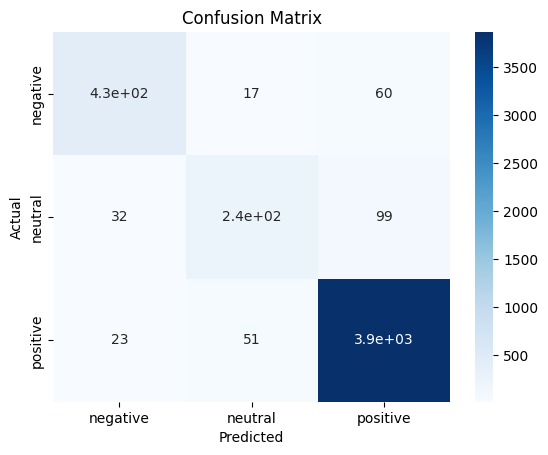

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [59]:
cm

array([[ 430,   17,   60],
       [  32,  245,   99],
       [  23,   51, 3866]])

In [149]:
## Will try to increase the precision of the other classes through different methods

In [ ]:
RandomForestClassifier().get_params()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define model
rf = RandomForestClassifier(class_weight='balanced',random_state=42)

# Define grid of hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# Grid search
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro',  # or 'accuracy' depending on your goal
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


In [153]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [154]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       507
           1       0.77      0.66      0.71       376
           2       0.97      0.98      0.97      3940

    accuracy                           0.94      4823
   macro avg       0.87      0.84      0.86      4823
weighted avg       0.94      0.94      0.94      4823



In [170]:
# Predict on the test set
y_pred = random_search.best_estimator_.predict(X_test)

# Generate classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       507
           1       0.81      0.67      0.73       376
           2       0.97      0.98      0.98      3940

    accuracy                           0.95      4823
   macro avg       0.88      0.84      0.86      4823
weighted avg       0.94      0.95      0.95      4823



In [179]:
import pandas as pd

# Assume test data is in X_test, y_test and you've got y_pred
X_test_df = pd.DataFrame(X_test.toarray(), columns=tfidf.get_feature_names_out())  # If using TF-IDF
original_reviews = data.loc[pd.Series(y_test).index, ['review','clean_text']]  # Use your original review text

errors = pd.DataFrame({
    "review": original_reviews['review'],
    "clean_text": original_reviews['clean_text'],
    "true_label": y_test,
    "predicted_label": y_pred
})

misclassified = errors[errors["true_label"] != errors["predicted_label"]]
print(misclassified.sample(10))  # Show 10 random misclassified samples


                                                 review  \
1724  Very good product. Item is bit pricy as per th...   
1533                     Perfect one for office workers   
3430  Product is excellent.But battery back up is ve...   
1855                 Expected better. Has hinge problem   
4115                                       Nice product   
4100                                       Nice product   
984                                 good for normal use   
1593                                         Loved it❤️   
1356  One and only best and affordable price range l...   
3657  One of the best laptop of this price. Display,...   

                                             clean_text  true_label  \
1724  good product item bit pricy spec provide hp ok...           0   
1533                              perfect office worker           2   
3430  product excellent battery poor 100 battery cha...           1   
1855                          expect well hinge problem           

In [180]:
misclassified.to_clipboard(index=False)

In [183]:
# Best Parameters: {'rf__max_depth': None, 'rf__max_features': 'log2',
#                   'rf__min_samples_split': 2, 'rf__n_estimators': 271}
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'clf' is not defined

In [157]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]
    
    model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)

    print(f"\nFold {fold+1}")
    print(classification_report(y_val, y_pred))



Fold 1
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       394
           1       0.88      0.55      0.68       331
           2       0.94      0.99      0.97      3133

    accuracy                           0.94      3858
   macro avg       0.91      0.79      0.83      3858
weighted avg       0.93      0.94      0.93      3858


Fold 2
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       394
           1       0.89      0.49      0.63       332
           2       0.94      0.99      0.96      3132

    accuracy                           0.93      3858
   macro avg       0.90      0.75      0.80      3858
weighted avg       0.93      0.93      0.92      3858


Fold 3
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       394
           1       0.94      0.48      0.64       332
           2       0.93      0.99      0.96      31

In [158]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(**grid_search.best_params_, random_state=42))
])

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]
    
    # Fit the pipeline on the training data
    pipeline.fit(X_tr, y_tr)
    
    # Predict on the validation data
    y_pred = pipeline.predict(X_val)

    # Output performance metrics
    print(f"\nFold {fold+1}")
    print(classification_report(y_val, y_pred))



Fold 1
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       394
           1       0.70      0.61      0.65       331
           2       0.96      0.97      0.96      3133

    accuracy                           0.92      3858
   macro avg       0.82      0.81      0.82      3858
weighted avg       0.92      0.92      0.92      3858


Fold 2
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       394
           1       0.68      0.57      0.62       332
           2       0.96      0.96      0.96      3132

    accuracy                           0.92      3858
   macro avg       0.81      0.80      0.80      3858
weighted avg       0.92      0.92      0.92      3858


Fold 3
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       394
           1       0.73      0.56      0.63       332
           2       0.96      0.97      0.96      31

NameError: name 'data' is not defined